# MFLES
> MFLES is a simple time series method based on gradient boosting time series decomposition.

There are numerous methods that can enter the boosting loop depending on user-provided parameters or some quick logic MFLES does automatically that seems to work ok. Some of these methods are:

1. SES Ensemble
2. Simple Moving Average
3. Piecewise Linear Trend
4. Fourier Basis function regression for seasonality
5. Simple Median
6. A Robust Linear Method for trend

# **Gradient Boosted Decomposition**

This approach aims to view a time series decomposition (trend, seasonality, and exogenous) as the 'weak' estimator in a gradient boosting procedure.

![](../../imgs/mfles_diagram.png)

The major relevant changes to note are:

1. The trend estimator will always go from simple to complex. Beginning with a median, then to a linear/piecewise linear, then to some sort of smoother.
2. Multiple seasonality is fit one seasonality per boosting round rather than simultaneously. This means you should organize your seasonality in order of perceived importance. Also, theoretically, you can have up to 50 seasonalities present by default, but after 3 you should expect degraded performance.
3. Learning rates are now estimator specific rather than a single parameter like you would see in something like XGBoost. This is useful if you have exogenous signals that are also seasonal, you (this will not be done automatically) can optimize for the combination of the seasonal signal and the exogenous signal.

# **Let's forecast**

In [ ]:
# %pip install statsforecast

Here, we will use the specific model object in Statsforecast and the infamous airline passengers dataset 😀:

In [ ]:
import pandas as pd
import numpy as np
from statsforecast.models import AutoMFLES
import matplotlib.pyplot as plt

df = pd.read_csv(r'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
y = df['Passengers'].values # make array


mfles_model = AutoMFLES(
      season_length = [12],
      test_size = 12,
      n_windows=2,
      metric = 'smape')
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

/hdd/github/statsforecast/statsforecast/core.py:30: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


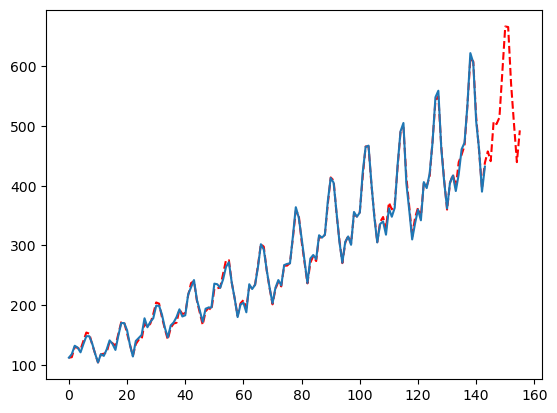

In [ ]:
plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

Let's take a look at some of the key parameters for a standard experience.

* **season_length**: a list of seasonal periods, in order of perceived importance preferably.
* **test_size**: AutoMFLES is optimized via time series cross validation. The test size dictates how many periods to use in each test fold. **This is probably the most important parameter when it comes to optimizing and you should weigh the season length, forecast horizon, and general data length when setting this. But a good rule of thumb is either the most important season length or half that to allow MFLES to pick up on seasonality.**

* **n_windows**: how many test sets are used in optimizing parameters. In this example, 2 means that we, in total, use 24 months (12 * 2) split between the 2 windows.
* **metric**: this one is easy, it is simply the metric we want to optimize for with our parameters. Here we use the default which is smape that is defaulted to reproduce experiment results on M4. You can also pass 'rmse', 'mape', or 'mae' to optimize for another metric.

# **A deeper look at a more customized model**

The previous fit is done with 99% automated logic checks and grid searched parameters. But we can manipulate the fit greatly (maybe too much). This section will overview some very important parameters and how they effect the output.

## **The parameter grid search**
First, let's take a look at the default grid of parameters AutoMFLES will try:

```python
config = {
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [int(min(seasonal_period)), int(min(seasonal_period)/2),None],
    'seasonal_period': [None, seasonal_period],
}
```

*   **seasonality_weights**: If True, we will weigh more recent observations more when calculating seasonality. The allows a deterministic seasonality to reflect more recent changes.
*   **smoother**: True means we will use a simple exponential smoother to fit on residuals after a few rounds of boosting. If the parameter is False then we use a simple moving average
*   **ma**: This parameter is the number of past observations to include when using a moving average, None indicates it will be semi-auto set or disregarded in the case of 'smoother' being True. For optimizing we search for the minimum season length provided by you or that number divided by 2.
*   **seasonal_period**: this is the list of season_length provided by the you

Now let's see how to pass the config to AutoMFLES, since this is what we use under-the-hood the results will be the same!

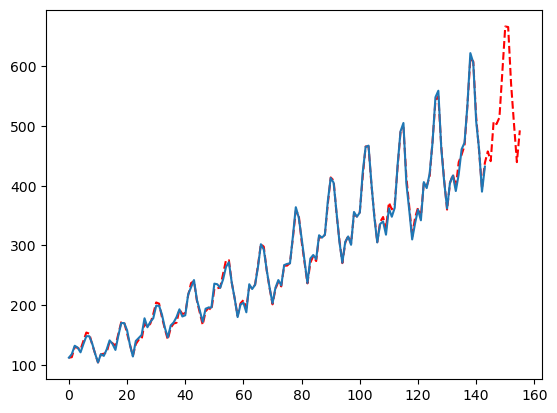

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

### What if you want to force a less reactive forecast?
Just pass False for the smoother and adjust ma to be larger relative to your seasonality

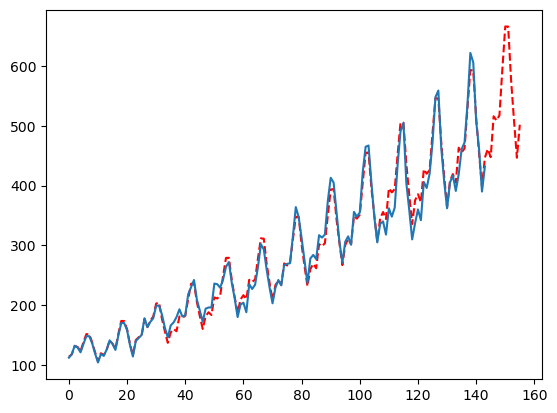

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [False],
    'ma': [30],
    'seasonal_period': [None, season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

### **Forcing** **Seasonality**
Sometimes a seasonal series is auto-fit with a nonseasonal setting, to adjust this and force seasonality, jsut remove the 'None' setting in the seasonal_period list.

This also reduces the number of configurations MFLES tries and therefore speeds up the fitting.

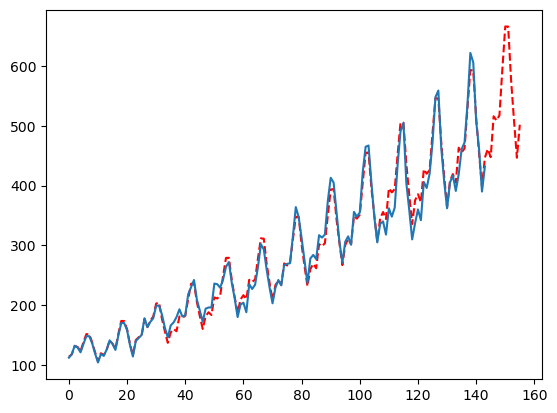

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [False],
    'ma': [30],
    'seasonal_period': [season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

## **Controlling the Complexity**
One of the best ways to control for complexity is with the max_rounds parameter. By default this is set to 50 but most of the time the model converges much quicker than that. At round 4 we start implementing smoothers as the trend piece so if you do not want that then set the max_rounds to 3! But, you probably want the smoothers!

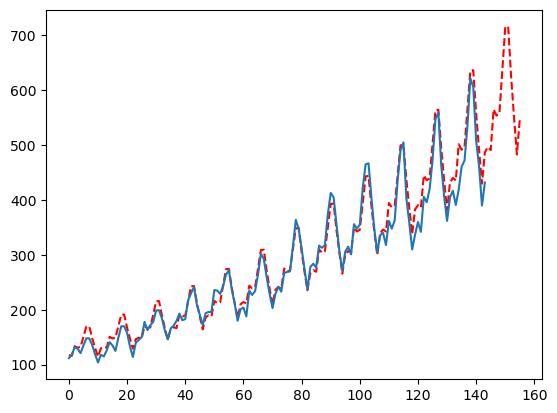

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    'max_rounds': [3],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

You can also leverage estimator specific learning rates which are applied to individual estimators rather than the entire boosting round. Useful if you notice that the residual smoother is eating too much signal too quickly:

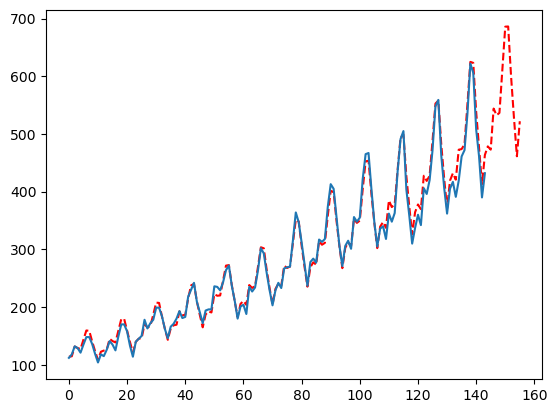

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    'rs_lr': [.2],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

## **Tips and Tricks**
Since most settings are optimized for during cross validation there is always a trade-off between accuracy and computation.


The default settings were done after extensive testing to give you a balanced approach. Hopefully, it delivers good accuracy in a short amount of time.

But, there are ways to give you generally more accuracy (not life changing but a slight boost) or a dramatic decrease in runtime (without sacrificing too much accuracy).

The next section will review some of those settings!



## **Number of Testing Windows**
When optimizing using time series cross validation the number of windows directly effects the number of times we have to fit the model for each parameter. The default here is 2, but going up to 3 (if your data allows it) should give you more consistent results. Obviously, the more the better to a certain point but this will depend on your data. Conversely, decreasing this to 1 means you are choosing parameters based on a single holdout set which may decrease accuracy.

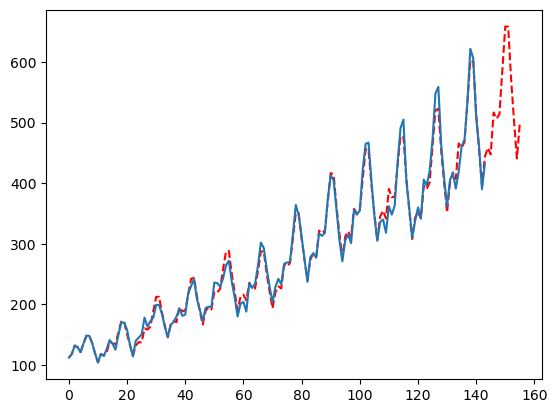

In [ ]:
season_length = [12]

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows = 1, # Trying just 1 window here
      metric = 'smape')
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

And now trying with 3, notice the fit is different!

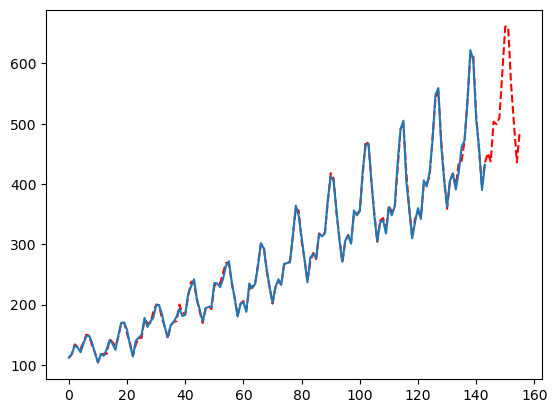

In [ ]:
season_length = [12]

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows = 3, # Trying just 1 window here
      metric = 'smape')
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

## **The Moving Average Parameter**
By default, we will try the min of your season lengths and half that for the 'ma' parameter. This works well in the wild but you may want to deepen this search greatly. **This is one of the best parameters to tweak if you need more accuracy out of MFLES**. Simply pass more parameters to the list, ideally these numbers are informed by the seasonality, forecast horizon, or some other bit of information. In our case, I will also pass 3 and 4 due to it being monthly data. Since this increases the number of parameters to try, it will also increase the computation time.

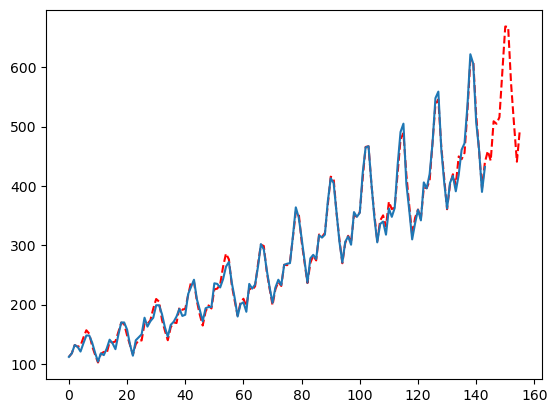

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [3, 4, int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

### **Changepoints**
By default, MFLES will auto-detect if it should use changepoints. This has some accuracy benefits but massive computation expenses. You can disable changepoints and generally see close accuracy but great speed gains:

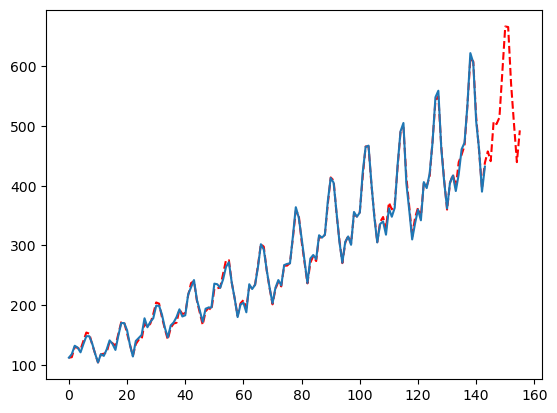

In [ ]:
season_length = [12]

config = {
    'changepoints': [False],
    'seasonality_weights': [True, False],
    'smoother': [True, False],
    'ma': [int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()

### **Seasonality Weights**
Most time series will not have a significant shift in the seasonal signal, or at least not one that is worth the extra computation needed to fit for it. To speed things up a bit, you can disable this. Although, sometimes, disabling this will cause large degradation in accuracy.

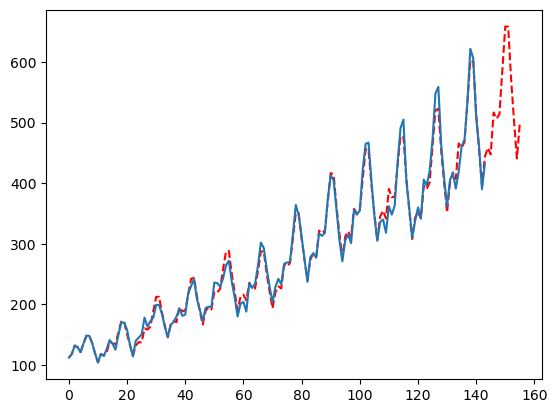

In [ ]:
season_length = [12]

config = {
    'seasonality_weights': [False],
    'smoother': [True, False],
    'ma': [int(min(season_length)), int(min(season_length)/2),None],
    'seasonal_period': [None, season_length],
    }

mfles_model = AutoMFLES(
      season_length = season_length,
      test_size = 12,
      n_windows=2,
      metric = 'smape',
      config=config) # adding the config dictionary manually
mfles_model.fit(y=y)
predicted = mfles_model.predict(12)['mean']
fitted = mfles_model.predict_in_sample()['fitted']

plt.plot(np.append(fitted, predicted), linestyle='dashed', color='red')
plt.plot(y)
plt.show()